In [1]:
emp = "exp_104_"

In [2]:
import numpy as np 
import pandas as pd 
import re
import typing as tp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm

import os
from glob import glob

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA

from collections import Counter
pd.set_option('display.max_columns', 100)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


import category_encoders as ce
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)

import warnings
warnings.simplefilter('ignore')

In [3]:
train_df = pd.read_csv("../train_data.csv")
test_df = pd.read_csv("../test_data.csv")
game_df = pd.read_csv("../game_info.csv")
game_df = game_df.drop('Unnamed: 0',axis=1)

# bool型が面倒なので、先に変換する
bool_list = ["b1", "b2", "b3"]
for i in bool_list:
    train_df[i] = train_df[i]*1
    test_df[i] = test_df[i]*1

# baselineとして、train_dfにしかないデータは削除する。
# 実験のどこかで追加できるように前処理をかける
_train_df = train_df.copy()
drop_list = [
    "pitchType", "speed", "ballPositionLabel", "ballX",
    "ballY", "dir", "dist", "battingType", "isOuts"
]
train_df = train_df.drop(drop_list, axis=1)

In [4]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        

In [5]:
# 前処理前の準備として実施する
train_df["counts"] = train_df[['S', 'B']].apply(lambda x: '{}-{}'.format(x[0], x[1]),axis=1)
test_df["counts"] = test_df[['S', 'B']].apply(lambda x: '{}-{}'.format(x[0], x[1]),axis=1)
_train_df["counts"] = _train_df[['S', 'B']].apply(lambda x: '{}-{}'.format(x[0], x[1]),axis=1)

# exp4との差
train_df["total_counts"] = train_df[['S', 'B', 'O']].apply(lambda x: '{}-{}-{}'.format(x[0], x[1], x[2]),axis=1)
test_df["total_counts"] = test_df[['S', 'B', 'O']].apply(lambda x: '{}-{}-{}'.format(x[0], x[1], x[2]),axis=1)

# exp5との差
train_df["runner_status"] = train_df[['b1', 'b2', 'b3']].apply(lambda x:'{}-{}-{}'.format(x[0], x[1], x[2]), axis=1)
test_df["runner_status"] = test_df[['b1', 'b2', 'b3']].apply(lambda x:'{}-{}-{}'.format(x[0], x[1], x[2]), axis=1)

# exp34から
train_df["runner_and_count"] = train_df[['b1', 'b2', 'b3', 'S', 'B','O']].apply(lambda x:'{}-{}-{}-{}-{}-{}'.format(x[0], 
                                                                                                                    x[1],
                                                                                                                    x[2],
                                                                                                                    x[3],
                                                                                                                    x[4],
                                                                                                                    x[5],), axis=1)
test_df["runner_and_count"] = test_df[['b1', 'b2', 'b3', 'S', 'B','O']].apply(lambda x:'{}-{}-{}-{}-{}-{}'.format(x[0], 
                                                                                                                  x[1],
                                                                                                                  x[2],
                                                                                                                  x[3],
                                                                                                                  x[4],
                                                                                                                  x[5],), axis=1)

train_df["runner_and_out"] = train_df[['b1', 'b2', 'b3','O']].apply(lambda x:'{}-{}-{}-{}'.format(x[0], x[1], x[2], x[3]), axis=1)
test_df["runner_and_out"] = test_df[['b1', 'b2', 'b3','O']].apply(lambda x:'{}-{}-{}-{}'.format(x[0], x[1], x[2], x[3]), axis=1)

train_df["runner_status2"] = train_df[['b2', 'b3']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)
test_df["runner_status2"] = test_df[['b2', 'b3']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)

train_df["runner_status3"] = train_df[['b1', 'b3']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)
test_df["runner_status3"] = test_df[['b1', 'b3']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)

train_df["runner_status4"] = train_df[['b1', 'b2']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)
test_df["runner_status4"] = test_df[['b1', 'b2']].apply(lambda x:'{}-{}'.format(x[0], x[1]), axis=1)

# exp55
train_df["total_counts2"] = train_df[['S', 'B', 'O', 'totalPitchingCount']].apply(lambda x: '{}-{}-{}-{}'.format(x[0], x[1], x[2],x[3]),axis=1)
test_df["total_counts2"] = test_df[['S', 'B', 'O','totalPitchingCount']].apply(lambda x: '{}-{}-{}-{}'.format(x[0], x[1], x[2],x[3]),axis=1)

# exp63
_train_df["speed"] = _train_df["speed"].str.extract(r'(\d+)').astype(float).replace(44.,137.0)[0]

# exp69
train_df['innings'] = 2 * (train_df['inning'].str[0].astype(int) - 1) + train_df['inning'].str.contains('裏')
test_df['innings'] = 2 * (test_df['inning'].str[0].astype(int) - 1) + test_df['inning'].str.contains('裏')
_train_df['innings'] = 2 * (_train_df['inning'].str[0].astype(int) - 1) + _train_df['inning'].str.contains('裏')

# なんで再度は3飛ばして4掛けている？
train_df['b1_b2_b3'] = train_df['b1'] * 1 + train_df['b2'] * 2 + train_df['b3'] * 4
test_df['b1_b2_b3'] = test_df['b1'] * 1 + test_df['b2'] * 2 + test_df['b3'] * 4

# ここの計算も？
train_df['B_S_O'] = train_df['B'] + 4 * (train_df['S'] + 3 * train_df['O'])
test_df['B_S_O'] = test_df['B'] + 4 * (test_df['S'] + 3 * test_df['O'])

train_df['outCount'] = train_df['innings'] * 3 + train_df['O']
_train_df['outCount'] = _train_df['innings'] * 3 + train_df['O']
test_df['outCount'] = test_df['innings'] * 3 + test_df['O']

train_df = train_df.drop("innings", axis=1)
_train_df = _train_df.drop("innings", axis=1)
test_df = test_df.drop("innings", axis=1)

# exp91
_train_df["ballXY"] = _train_df["ballX"].astype(str) + "_" + _train_df["ballY"]

In [6]:
# メモリ使用量削減
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024**2
    cols = df.columns.to_list()
    df_1 = df.select_dtypes(exclude=['integer', 'float'])
    df_2 = df.select_dtypes(include=['integer']).apply(pd.to_numeric, downcast='integer')
    df_3 = df.select_dtypes(include=['float']).apply(pd.to_numeric, downcast='float')
    df = df_1.join([df_2, df_3]).loc[:, cols]
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.2f}Mb->{:.2f}Mb({:.1f}% reduction)'.format(
            start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# random_sampling
# 実装しないとまずいのか？

def random_sampling(input_df, n_sample=10):
    dfs = []
    tr_df = input_df[input_df['y'].notnull()].copy()
    ts_df = input_df[input_df['y'].isnull()].copy()
    for i in tqdm(range(n_sample)):
        df = tr_df.groupby(['gameID', 'outCount']).apply(lambda x: x.sample(n=1, random_state=i+70)).reset_index(drop=True)
        df['subGameID'] = df['gameID'] * n_sample + i
        dfs.append(df)
    ts_df['subGameID'] = ts_df['gameID'] * n_sample
    return pd.concat(dfs,axis=0), ts_df

# 後ろ処理用
def random_sampling_dummy(input_df, n_sample=10):
    dfs = []
    tr_df = input_df[input_df['y'].notnull()].copy()
    ts_df = input_df[input_df['y'].isnull()].copy()
    for i in tqdm(range(n_sample)):
        df = tr_df.groupby(['gameID', 'outCount']).apply(lambda x: x.sample(n=1, random_state=i+10)).reset_index(drop=True)
        df['subGameID'] = df['gameID'] * n_sample + i
        dfs.append(df)
    ts_df['subGameID'] = ts_df['gameID'] * n_sample
    return pd.concat(dfs,axis=0)

In [8]:
# train_df, test_dfの更新を行う
temp = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_df, test_df = random_sampling(temp, n_sample=10)
# yを削除しておく
test_df = test_df.drop("y", axis=1)
# train_dfのindexを振り直す
train_df = train_df.reset_index(drop=True)
print(len(train_df))
print(len(test_df))

100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

29920
33808


<AxesSubplot:>

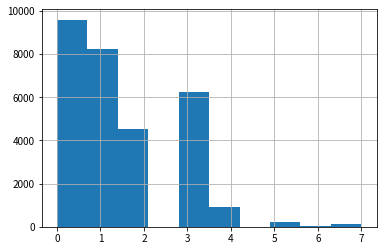

In [9]:
train_df.y.hist()

In [10]:
train_df

,id,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,pitcherHand,batter,batterHand,gameID,inning,y,counts,total_counts,runner_status,runner_and_count,runner_and_out,runner_status2,runner_status3,runner_status4,total_counts2,b1_b2_b3,B_S_O,outCount,subGameID
0,16275,2,1,0,0,0,0,0,高橋 光成,R,中川 圭太,R,20202116,1回表,0.0,0-1,0-1-0,0-0-0,0-0-0-0-1-0,0-0-0-0,0-0,0-0,0-0,0-1-0-2,0,1,0,202021160
1,16279,2,1,0,1,0,0,0,高橋 光成,R,安達 了一,R,20202116,1回表,1.0,0-1,0-1-1,0-0-0,0-0-0-0-1-1,0-0-0-1,0-0,0-0,0-0,0-1-1-2,0,13,1,202021160
2,19545,1,0,0,2,0,0,0,高橋 光成,R,吉田 正尚,L,20202116,1回表,0.0,0-0,0-0-2,0-0-0,0-0-0-0-0-2,0-0-0-2,0-0,0-0,0-0,0-0-2-1,0,24,2,202021160
3,16291,2,0,1,0,0,0,0,アルバース,L,鈴木 将平,L,20202116,1回裏,1.0,1-0,1-0-0,0-0-0,0-0-0-1-0-0,0-0-0-0,0-0,0-0,0-0,1-0-0-2,0,4,3,202021160
4,16295,2,1,0,1,0,0,0,アルバース,L,源田 壮亮,L,20202116,1回裏,1.0,0-1,0-1-1,0-0-0,0-0-0-0-1-1,0-0-0-1,0-0,0-0,0-0,0-1-1-2,0,13,4,202021160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29915,870,3,0,2,0,0,0,0,エドワーズ,R,中島 宏之,R,20202175,8回裏,3.0,2-0,2-0-0,0-0-0,0-0-0-2-0-0,0-0-0-0,0-0,0-0,0-0,2-0-0-3,0,8,45,202021759
29916,872,2,0,1,1,0,0,0,エドワーズ,R,パーラ,L,20202175,8回裏,0.0,1-0,1-0-1,0-0-0,0-0-0-1-0-1,0-0-0-1,0-0,0-0,0-0,1-0-1-2,0,16,46,202021759
29917,881,3,1,1,2,1,0,0,エドワーズ,R,炭谷 銀仁朗,R,20202175,8回裏,3.0,1-1,1-1-2,1-0-0,1-0-0-1-1-2,1-0-0-2,0-0,1-0,1-0,1-1-2-3,1,29,47,202021759
29918,883,2,1,0,0,0,0,0,デラロサ,R,マルテ,R,20202175,9回表,4.0,0-1,0-1-0,0-0-0,0-0-0-0-1-0,0-0-0-0,0-0,0-0,0-0,0-1-0-2,0,1,48,202021759


In [11]:
# このあとの処理のために
_train_df = random_sampling_dummy(_train_df)
_train_df = _train_df.drop(["outCount", "subGameID"],axis=1)
_train_df = _train_df.reset_index(drop=True)

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


In [12]:
# baseBlock 

class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")
    
# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [13]:
# 前処理の追加をする関数
def get_top_bottom(x):
    if '表' in x:
        return 0
    else:
        return 1

def get_inning(input_df):
    output_df = pd.DataFrame()
    
    output_df['top_bottom'] = input_df['inning'].apply(lambda x: get_top_bottom(x))
    output_df['inning_num'] = input_df['inning'].apply(lambda x: re.sub("\\D", "", x)).astype(int)
    
    # 出力のdfにメモリ削減を入れるのはいいと思う
    return reduce_mem_usage(output_df)

# ピッチャー左対バッター右
def left_vs_right(x, y):
    if x=="L" and y=='R':
        return 1
    else:
        return 0

def right_vs_left(x,y):
    if x=='R' and y=='L':
        return 1
    else:
        return 0

def get_pvsb(input_df):
    output_df = pd.DataFrame()
    output_df['left_right'] = input_df[['pitcherHand', 'batterHand']].apply(lambda x: left_vs_right(x[0], x[1]),axis=1)
    output_df['right_left'] = input_df[['pitcherHand', 'batterHand']].apply(lambda x: right_vs_left(x[0], x[1]),axis=1)
    
    return reduce_mem_usage(output_df)

def get_agg_inning(input_df):
    cols = "inning"
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                     group_key = cols,
                                     group_values = ["totalPitchingCount"],
                                     agg_methods = ["max","median", "mean", "std", "var"]
                                     )
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]


def get_agg_runner_status(input_df):
    cols = "runner_status"
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                     group_key=cols,
                                     group_values=["totalPitchingCount"],
                                     agg_methods = ["max", "median", "mean", "std", "var"]
                                     )
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]


def full_count_search(x,y):
    if x==3 and y==2:
        return 1
    else:
        return 0


def get_full_count(input_df):
    output_df = pd.DataFrame()
    
    output_df["full_count"] = input_df[["B", "S"]].apply(lambda x: full_count_search(x[0], x[1]), axis=1)
    
    return reduce_mem_usage(output_df)

# 対戦カードの情報を追加する
def get_match(input_df):
    _input_df = pd.merge(input_df, game_df, on="gameID", how="left")
    _input_df["match"] = _input_df["topTeam"] + "vs" + _input_df["bottomTeam"]
    
    cols = [
        "match"
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    
    return reduce_mem_usage(output_df)

# セ・パの情報を入れる（追加で日本シリーズかどうかも判定）
def search_central_league(x, y):
    central_team = ['巨人', 'DeNA','ヤクルト', '広島', '中日', '阪神']
    if x in central_team and y in central_team:
        return 1
    else:
        return 0
    
#n日本シリーズのデータがtestにしかないから、意味ない？
def search_japan_series(x, y):
    card_team = ['ソフトバンク', '巨人']
    if x in card_team and y in card_team:
        return 1
    elif y in card_team and x in card_team:
        return 1
    else:
        return 0
    
# 判定結果を特徴量に
def get_league(input_df):
    _input_df = pd.merge(input_df, game_df, on="gameID", how="left")
    output_df = pd.DataFrame()
    
    output_df["league"] = _input_df[["topTeam", "bottomTeam"]].apply(lambda x: search_central_league(x[0], x[1]), axis=1)
    #output_df["japan_series"] = _input_df[["topTeam", "bottomTeam"]].apply(lambda x: search_japan_series(x[0], x[1]), axis=1)
    
    return reduce_mem_usage(output_df)

# その回何人目のバッターなのかのフラグ
def get_count_batter(input_df):
    output_df = pd.DataFrame()
    
    output_df["count_batter"] = input_df["O"]+input_df["b1"]+input_df["b2"]+input_df["b3"]+1
    
    return reduce_mem_usage(output_df)

# ホームラン数が多い人に対してのフラグを実装（OHEなくしたから効果あるか）
def search_HR_batter(x):
    HR_list = ['岡本 和真','レアード','山川 穂高','中田 翔','鈴木 誠也','浅村 栄斗']
    
    if x in HR_list:
        return 1
    else:
        return 0
    
def get_HR_batter(input_df):
    output_df = pd.DataFrame()
    output_df["HR_batters_flag"] = input_df.batter.apply(lambda x: search_HR_batter(x))
    
    return reduce_mem_usage(output_df)

# ホームラン数に関するフラグが少し効果あったので、投手（奪三振でも実施）
def search_KK_pitcher(x):
    KK_list =['ムーア', '森下 暢仁', '柳 裕也', '杉浦 稔大', '弓削 隼人', '山本 由伸', '戸郷 翔征', 'アルバース',
       '有原 航平', 'モイネロ', '石橋 良太', '高橋 光成', '種市 篤暉', 'ギャレット', '則本 昂大', '菅野 智之',
       '梅津 晃大', '今永 昇太', 'ジャクソン', '中村 稔弥']
    
    if x in KK_list:
        return 1
    else:
        return 0
    
def get_KK_pitcher(input_df):
    output_df = pd.DataFrame()
    output_df["KK_pitcher_flag"] = input_df.pitcher.apply(lambda x: search_KK_pitcher(x))
    
    return reduce_mem_usage(output_df)

# average_hitter(効果なし)
def search_average_hitter(x):
    avg_hitter_list = ['宮崎 敏郎', '岡本 和真', '荻野 貴司', '高橋 周平', '鈴木 大地', 'ロメロ', '佐野 恵太', '京田 陽太',
       '浅村 栄斗']
    
    if x in avg_hitter_list:
        return 1
    else:
        return 0
    
def get_average_hitter(input_df):
    output_df = pd.DataFrame()
    output_df["average_hitter_flag"] = input_df.pitcher.apply(lambda x: search_average_hitter(x))
    
    return reduce_mem_usage(output_df)

# ピッチャーとバッターに球団情報を与える
def b_p_detail(input_df):
    _input_df = pd.merge(input_df, game_df, on='gameID', how='left')
    
    _input_df.loc[_input_df['inning'].str.contains("表"), "batter_detail"] = _input_df["batter"] + '_' + _input_df["topTeam"]
    _input_df.loc[_input_df['inning'].str.contains("裏"), "batter_detail"] = _input_df["batter"] + '_' + _input_df["bottomTeam"]
    _input_df.loc[_input_df['inning'].str.contains("表"), "pitcher_detail"] = _input_df["pitcher"] + '_' + _input_df["bottomTeam"]
    _input_df.loc[_input_df['inning'].str.contains("裏"), "pitcher_detail"] = _input_df["pitcher"] + '_' + _input_df["topTeam"]
    
    cols = [
        "batter_detail",
        "pitcher_detail"
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    
    return reduce_mem_usage(output_df)

def ballPositionLabel_ratio(input_df):
    # 球種ごとにpivottableを作成して、正規化
    _df = _train_df.pivot_table(values="id",index='pitcher',columns='ballPositionLabel',aggfunc='count').fillna(0).apply(lambda x: x/x.sum(), axis=1)
    
    output_df = pd.merge(input_df, _df, on="pitcher", how="left")
    
    agg_cols = ['内角低め', '外角高め', '内角中心', '外角中心', '真ん中低め', 'ど真ん中', '外角低め', '真ん中高め',
       '内角高め', '低め', '高め', '中心']
    
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def ballPositionLabel_ratio_b(input_df):
    # 球種ごとにpivottableを作成して、正規化
    _df = _train_df.pivot_table(values="id",index='batter',columns='ballPositionLabel',aggfunc='count').fillna(0).apply(lambda x: x/x.sum(), axis=1)
    
    output_df = pd.merge(input_df, _df, on="batter", how="left")
    output_df = output_df.rename(columns={'内角低め':'内角低め_b',
                                          '外角高め':'外角高め_b',
                                          '内角中心':'内角中心_b',
                                          '外角中心':'外角中心_b',
                                          '真ん中低め':'真ん中低め_b',
                                          'ど真ん中':'ど真ん中_b',
                                          '外角低め':'外角低め_b',
                                          '真ん中高め':'真ん中高め_b',
                                          '内角高め':'内角高め_b',
                                          '低め':'低め_b',
                                          '高め':'高め_b',
                                          '中心':'中心_b'})
    
    agg_cols = ['内角低め_b', '外角高め_b', '内角中心_b', '外角中心_b', '真ん中低め_b', 'ど真ん中_b', '外角低め_b', '真ん中高め_b',
       '内角高め_b', '低め_b', '高め_b', '中心_b']
    
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def ballPositionLabel_ratio_b_speed(input_df):
    # 球種ごとにpivottableを作成して、正規化
    _df = _train_df.pivot_table(values="speed",index='batter',columns='ballPositionLabel',aggfunc='max').fillna(137)
    
    output_df = pd.merge(input_df, _df, on="batter", how="left")
    output_df = output_df.rename(columns={'内角低め':'内角低め_b_speed',
                                          '外角高め':'外角高め_b_speed',
                                          '内角中心':'内角中心_b_speed',
                                          '外角中心':'外角中心_b_speed',
                                          '真ん中低め':'真ん中低め_b_speed',
                                          'ど真ん中':'ど真ん中_b_speed',
                                          '外角低め':'外角低め_b_speed',
                                          '真ん中高め':'真ん中高め_b_speed',
                                          '内角高め':'内角高め_b_speed',
                                          '低め':'低め_b_speed',
                                          '高め':'高め_b_speed',
                                          '中心':'中心_b_speed'})
    
    agg_cols = ['内角低め_b_speed', '外角高め_b_speed', '内角中心_b_speed', '外角中心_b_speed', '真ん中低め_b_speed', 
                'ど真ん中_b_speed', '外角低め_b_speed', '真ん中高め_b_speed','内角高め_b_speed', '低め_b_speed', '高め_b_speed', '中心_b_speed']
    
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def ballPositionLabel_ratio_p_speed(input_df):
    # 球種ごとにpivottableを作成して、正規化
    _df = _train_df.pivot_table(values="speed",index='pitcher',columns='ballPositionLabel',aggfunc='max').fillna(137)
    
    output_df = pd.merge(input_df, _df, on="pitcher", how="left")
    output_df = output_df.rename(columns={'内角低め':'内角低め_p_speed',
                                          '外角高め':'外角高め_p_speed',
                                          '内角中心':'内角中心_p_speed',
                                          '外角中心':'外角中心_p_speed',
                                          '真ん中低め':'真ん中低め_p_speed',
                                          'ど真ん中':'ど真ん中_p_speed',
                                          '外角低め':'外角低め_p_speed',
                                          '真ん中高め':'真ん中高め_p_speed',
                                          '内角高め':'内角高め_p_speed',
                                          '低め':'低め_p_speed',
                                          '高め':'高め_p_speed',
                                          '中心':'中心_p_speed'})
    
    agg_cols = ['内角低め_p_speed', '外角高め_p_speed', '内角中心_p_speed', '外角中心_p_speed', '真ん中低め_p_speed', 
                'ど真ん中_p_speed', '外角低め_p_speed', '真ん中高め_p_speed','内角高め_p_speed', '低め_p_speed', '高め_p_speed', '中心_p_speed']
    
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]


def get_batting_average(input_df):
    # _train_dfから各打者ごとに打席数と、そのうちの安打数を取得する
    daseki_list = []
    anda_list = []
    subset_list = ['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
                   'pitcherHand', 'batter', 'batterHand', 'gameID', 'inning', 'pitchType',
                   'speed', 'ballPositionLabel', 'ballX', 'ballY', 'dir', 'dist',
                   'battingType', 'isOuts', 'y']
    
    _df = _train_df.copy()
    
    for i in train_df["batter"].unique():
        daseki = len(_df[(_df["batter"]==i)&(_df["totalPitchingCount"]==1)].drop_duplicates(subset=subset_list))
        __df = _df.loc[_df[train_df["batter"]==i].groupby(["gameID", "inning"])["totalPitchingCount"].idxmax(),:]
        anda = len(__df[__df["y"]>3])
        
        daseki_list.append(daseki)
        anda_list.append(anda)
        
    temp = pd.DataFrame({"batter":train_df["batter"].unique(),
                          "at_bats":daseki_list,
                          "Number_of_hits":anda_list})
    
    temp["batting_average"] = temp["Number_of_hits"] / temp["at_bats"]
    
    output_df = pd.merge(input_df, temp, on="batter", how="left")
    output_df["batting_average"].fillna(0, inplace=True)
    
    agg_cols = ["at_bats", "Number_of_hits", "batting_average"]
    
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]


In [14]:
# baselineから拝借
# https://prob.space/topics/DT-SN-Post2126e8f25865e24a1cc4

# 前後特徴量

def get_diff_feature(input_df, value_col, periods, in_inning=True, aggfunc=np.median):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=aggfunc)
    if in_inning:
        dfs = []
        for inning in range(9):
            df0 = pivot_df.loc[:, [out+inning*6 for out in range(0,3)]].diff(periods, axis=1)
            df1 = pivot_df.loc[:, [out+inning*6 for out in range(3,6)]].diff(periods, axis=1)
            dfs += [df0, df1]
        pivot_df = pd.concat(dfs, axis=1).stack()
    else:
        df0 = pivot_df.loc[:, [out+inning*6 for inning in range(9) for out in range(0,3)]].diff(periods, axis=1)
        df1 = pivot_df.loc[:, [out+inning*6 for inning in range(9) for out in range(3,6)]].diff(periods, axis=1)
        pivot_df = pd.concat([df0, df1], axis=1).stack()
    return pivot_df

def get_shift_feature(input_df, value_col, periods, in_inning=True, aggfunc=np.median):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=aggfunc)
    if in_inning:
        dfs = []
        for inning in range(9):
            df0 = pivot_df.loc[:, [out+inning*6 for out in range(0,3)]].shift(periods, axis=1)
            df1 = pivot_df.loc[:, [out+inning*6 for out in range(3,6)]].shift(periods, axis=1)
            dfs += [df0, df1]
        pivot_df = pd.concat(dfs, axis=1).stack()
    else:
        df0 = pivot_df.loc[:, [out+inning*6 for inning in range(9) for out in range(0,3)]].shift(periods, axis=1)
        df1 = pivot_df.loc[:, [out+inning*6 for inning in range(9) for out in range(3,6)]].shift(periods, axis=1)
        pivot_df = pd.concat([df0, df1], axis=1).stack()
    return pivot_df


In [15]:
# 自分のprocess関数に合わせ込むために、nan_valuesの値などを埋め込んでおく
def get_next_data(input_df, value_col='b1_b2_b3', in_inning=True, nan_value=8):
    pivot_df = get_shift_feature(input_df, value_col, periods=-1, in_inning=in_inning)
    pivot_df.name = 'next_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
    
    agg_cols = ["next_b1_b2_b3"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def get_prev_data(input_df, value_col='b1_b2_b3', in_inning=True, nan_value=8):
    pivot_df = get_shift_feature(input_df, value_col, periods=1, in_inning=in_inning)
    pivot_df.name = 'prev_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["prev_b1_b2_b3"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]
    
def get_next_diff(input_df, value_col='b1_b2_b3', in_inning=True, nan_value=8):
    pivot_df = get_diff_feature(input_df, value_col, periods=-1, in_inning=in_inning)
    pivot_df.name = 'next_diff_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["next_diff_b1_b2_b3"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def get_prev_diff(input_df, value_col='b1_b2_b3', in_inning=True, nan_value=8):
    pivot_df = get_diff_feature(input_df, value_col, periods=1, in_inning=in_inning)
    pivot_df.name = 'prev_diff_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["prev_diff_b1_b2_b3"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]


In [16]:
def get_next_data_BSO(input_df, value_col='B_S_O', in_inning=True, nan_value=8):
    pivot_df = get_shift_feature(input_df, value_col, periods=-1, in_inning=in_inning)
    pivot_df.name = 'next_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
    
    agg_cols = ["next_B_S_O"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def get_prev_data_BSO(input_df, value_col='B_S_O', in_inning=True, nan_value=8):
    pivot_df = get_shift_feature(input_df, value_col, periods=1, in_inning=in_inning)
    pivot_df.name = 'prev_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["prev_B_S_O"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]
    
def get_next_diff_BSO(input_df, value_col='B_S_O', in_inning=True, nan_value=8):
    pivot_df = get_diff_feature(input_df, value_col, periods=-1, in_inning=in_inning)
    pivot_df.name = 'next_diff_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["next_diff_B_S_O"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

def get_prev_diff_BSO(input_df, value_col='B_S_O', in_inning=True, nan_value=8):
    pivot_df = get_diff_feature(input_df, value_col, periods=1, in_inning=in_inning)
    pivot_df.name = 'prev_diff_' + value_col
    output_df = pd.merge(
        input_df, pivot_df, left_on=['subGameID', 'outCount'], right_index=True, how='left')
    if nan_value is not None:
        output_df[pivot_df.name].fillna(nan_value, inplace=True)
        
    agg_cols = ["prev_diff_B_S_O"]
    output_df = reduce_mem_usage(output_df)
    return output_df[agg_cols]

In [17]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

def get_skip(input_df):
    output_df = input_df.copy()
    # inningHalf追加
    output_df["innings"] = 2 * (input_df['inning'].str[0].astype(int) - 1) + input_df['inning'].str.contains('裏')
    output_df["inningHalf"] = output_df["innings"] % 2

    next_skip_map = {}
    prev_skip_map = {}
    for key, group in output_df.groupby(['subGameID', 'inningHalf']):
        n = len(group)
        dist_map = {}
        batter = group.sort_values('outCount')['batter']
        for i in range(n - 1):
            b1 = batter.iloc[i]
            for d in range(1, 5):
                if i + d >= n:
                    break
                b2 = batter.iloc[i + d]

                if (b1, b2) in dist_map.keys():
                    if dist_map[(b1, b2)] < d:
                        dist_map[(b1, b2)] = d
                else:
                    dist_map[(b1, b2)] = d
            
        for i in range(len(batter) - 1):
            next_skip_map[batter.index[i]] = dist_map[(batter.iloc[i], batter.iloc[i+1])]
        for i in range(1, len(batter)):
            prev_skip_map[batter.index[i]] = dist_map[(batter.iloc[i-1], batter.iloc[i])]

    output_df['next_skip'] = output_df.index.map(next_skip_map).fillna(0).astype(np.int8)
    output_df['prev_skip'] = output_df.index.map(prev_skip_map).fillna(0).astype(np.int8)
    
    agg_cols = ["next_skip", "prev_skip"]
    
    return output_df[agg_cols]

# tf-idf
def get_tfidf(input_df, term_col='batter', document_col='subGameID'):
    output_df = input_df.copy()
    output_df['dummy'] = 0
    
    tf1 = output_df[[document_col, term_col, 'dummy']].groupby([document_col, term_col])['dummy'].count()
    tf1.name = 'tf1'
    tf2 = output_df[[document_col, term_col, 'dummy']].groupby([document_col])['dummy'].count()
    tf2.name = 'tf2'
    
    idf1 = output_df[document_col].nunique()
    idf2 = output_df[[document_col, term_col, 'dummy']].groupby([term_col])[document_col].nunique()
    idf2.name = 'idf2'
    
    output_df = pd.merge(output_df, tf1, left_on=[document_col, term_col], right_index=True, how='left')
    output_df = pd.merge(output_df, tf2, left_on=[document_col], right_index=True, how='left')
    
    output_df['idf1'] = idf1
    output_df = pd.merge(output_df, idf2, left_on=[term_col], right_index=True, how='left')
    
    col_name = 'tfidf_' + term_col + '_in_' + document_col
    
    tf = np.log(1 + (1 + output_df['tf1']) / (1 + output_df['tf2']))
    idf = 1 + np.log((1 + output_df['idf1']) / (1 + output_df['idf2']))
    output_df[col_name] = tf * idf
    
    return output_df["tfidf_batter_in_subGameID"]


# pivot tabel を用いた特徴量
# nは次元数を指している
def get_pivot_NMF9_features(input_df, n=2, value_col='b1_b2_b3'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc0 = MinMaxScaler().fit_transform(np.median(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,0::2,:], axis=-1))
    sc1 = MinMaxScaler().fit_transform(np.median(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,1::2,:], axis=-1))
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df0 = pd.DataFrame(nmf.fit_transform(sc0), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF9T={x:02}')
    nmf_df1 = pd.DataFrame(nmf.fit_transform(sc1), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF9B={x:02}')
    nmf_df = pd.concat([nmf_df0, nmf_df1], axis=1)
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_b1_b2_b3_NMF9B=00", "pivot_b1_b2_b3_NMF9B=01"]
    
    return nmf_df[agg_cols]

# pivot tabel を用いた特徴量
def get_pivot_NMF27_features(input_df, n=2, value_col='b1_b2_b3'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc0 = MinMaxScaler().fit_transform(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,0::2].reshape(-1,27))
    sc1 = MinMaxScaler().fit_transform(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,1::2].reshape(-1,27))
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df0 = pd.DataFrame(nmf.fit_transform(sc0), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF27T={x:02}')
    nmf_df1 = pd.DataFrame(nmf.fit_transform(sc1), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF27B={x:02}')
    nmf_df = pd.concat([nmf_df0, nmf_df1], axis=1)
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_b1_b2_b3_NMF27T=00", "pivot_b1_b2_b3_NMF27T=01"]
    
    return nmf_df[agg_cols]

# pivot tabel を用いた特徴量
def get_pivot_NMF54_features(input_df, n=2, value_col='b1_b2_b3'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc = MinMaxScaler().fit_transform(pivot_df.fillna(0).values)
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df = pd.DataFrame(nmf.fit_transform(sc), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF54={x:02}')
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_b1_b2_b3_NMF54=00", "pivot_b1_b2_b3_NMF54=01"]
    
    return nmf_df[agg_cols]


# exp80
def get_tfidf_p(input_df, term_col='pitcher', document_col='subGameID'):
    output_df = input_df.copy()
    output_df['dummy'] = 0
    
    tf1 = output_df[[document_col, term_col, 'dummy']].groupby([document_col, term_col])['dummy'].count()
    tf1.name = 'tf1'
    tf2 = output_df[[document_col, term_col, 'dummy']].groupby([document_col])['dummy'].count()
    tf2.name = 'tf2'
    
    idf1 = output_df[document_col].nunique()
    idf2 = output_df[[document_col, term_col, 'dummy']].groupby([term_col])[document_col].nunique()
    idf2.name = 'idf2'
    
    output_df = pd.merge(output_df, tf1, left_on=[document_col, term_col], right_index=True, how='left')
    output_df = pd.merge(output_df, tf2, left_on=[document_col], right_index=True, how='left')
    
    output_df['idf1'] = idf1
    output_df = pd.merge(output_df, idf2, left_on=[term_col], right_index=True, how='left')
    
    col_name = 'tfidf_' + term_col + '_in_' + document_col
    
    tf = np.log(1 + (1 + output_df['tf1']) / (1 + output_df['tf2']))
    idf = 1 + np.log((1 + output_df['idf1']) / (1 + output_df['idf2']))
    output_df[col_name] = tf * idf
    
    return output_df["tfidf_pitcher_in_subGameID"]

# exp81
# pivot tabel を用いた特徴量
# nは次元数を指している
def get_pivot_NMF9_features_BSO(input_df, n=2, value_col='B_S_O'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc0 = MinMaxScaler().fit_transform(np.median(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,0::2,:], axis=-1))
    sc1 = MinMaxScaler().fit_transform(np.median(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,1::2,:], axis=-1))
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df0 = pd.DataFrame(nmf.fit_transform(sc0), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF9T={x:02}')
    nmf_df1 = pd.DataFrame(nmf.fit_transform(sc1), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF9B={x:02}')
    nmf_df = pd.concat([nmf_df0, nmf_df1], axis=1)
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_B_S_O_NMF9B=00", "pivot_B_S_O_NMF9B=01"]
    
    return nmf_df[agg_cols]

# pivot tabel を用いた特徴量
def get_pivot_NMF27_features_BSO(input_df, n=2, value_col='B_S_O'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc0 = MinMaxScaler().fit_transform(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,0::2].reshape(-1,27))
    sc1 = MinMaxScaler().fit_transform(pivot_df.fillna(0).values.reshape(-1,54//3,3)[:,1::2].reshape(-1,27))
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df0 = pd.DataFrame(nmf.fit_transform(sc0), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF27T={x:02}')
    nmf_df1 = pd.DataFrame(nmf.fit_transform(sc1), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF27B={x:02}')
    nmf_df = pd.concat([nmf_df0, nmf_df1], axis=1)
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_B_S_O_NMF27T=00", "pivot_B_S_O_NMF27T=01"]
    
    return nmf_df[agg_cols]

# pivot tabel を用いた特徴量
def get_pivot_NMF54_features_BSO(input_df, n=2, value_col='B_S_O'):
    pivot_df = pd.pivot_table(input_df, index='subGameID', columns='outCount', values=value_col, aggfunc=np.median)
    sc = MinMaxScaler().fit_transform(pivot_df.fillna(0).values)
    nmf = NMF(n_components=n, random_state=2021)
    nmf_df = pd.DataFrame(nmf.fit_transform(sc), index=pivot_df.index).rename(
        columns=lambda x: f'pivot_{value_col}_NMF54={x:02}')
    nmf_df = pd.merge(
        input_df, nmf_df, left_on='subGameID', right_index=True, how='left')
    
    agg_cols = ["pivot_B_S_O_NMF54=00", "pivot_B_S_O_NMF54=01"]
    
    return nmf_df[agg_cols]

In [18]:
# exp91

def result_description_pca_pre(N,data):
    pca = PCA(n_components=N).fit(data)
    transformed = pca.transform(data)
    ratio_list = []
    
    output_df = pd.DataFrame(transformed)

    output_df.index = data.index
    col = [data.columns.name + "_"+str(i) for i in range(N)]
    output_df.reset_index(drop=True)
    output_df.columns = col
    
    output_df = output_df.reset_index()
    return output_df

def pca_ball_position_counts(input_df):
    # ballXY（ballXとballの組み合わせ）を作成して、countとcrosstab
    temp_df = pd.crosstab(_train_df["counts"], _train_df["ballXY"], normalize="index")
    
    result_feature = result_description_pca_pre(8, temp_df)
    agg_cols = result_feature.columns.tolist()
    agg_cols.remove("counts")
    
    output_df = pd.merge(input_df, result_feature, on="counts", how="left")
    
    
    return output_df[agg_cols]

In [19]:
# encoding系の処理を行う関数
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        'pitcher',
        'pitcherHand',
        'batter',
        'batterHand',
        'inning',
        'counts',
        'total_counts',
        'runner_status',
        "runner_and_count",
        "runner_and_out",
        "runner_status2",
        "runner_status3",
        "runner_status4",
        'total_counts2'
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        #'pitcher',
        'pitcherHand',
        #'batter',
        'batterHand',
        'inning',
        'counts',
        'total_counts',
        'runner_status',
        "runner_and_count",
        "runner_and_out",
        "runner_status2",
        "runner_status3",
        "runner_status4",
        'total_counts2'
    ]
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
       #'pitcher',
        'pitcherHand',
        #'batter',
        'batterHand',
        'inning',
        'counts',
        'total_counts',
        'runner_status',
        "runner_and_count",
        "runner_and_out",
        "runner_status2",
        "runner_status3",
        "runner_status4",
        'total_counts2'
    ]
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df


# numeric_feature
def create_numeric_feature(input_df):
    use_columns = [
        'totalPitchingCount',
        'B', 'S', 'O','b1', 'b2', 'b3',"gameID"
    ]

    return input_df[use_columns].copy()

In [20]:
# 前処理関数を順々に処理していく関数
def to_features(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features,
        get_ce_features,
        get_ohe_features,
        create_numeric_feature,
        get_inning,
        get_pvsb,
        get_agg_inning,
        get_agg_runner_status,
        get_full_count,
        get_match,
        get_league,
        get_count_batter,
        get_HR_batter,
        get_KK_pitcher,
        ballPositionLabel_ratio,
        ballPositionLabel_ratio_b,
        #ballPositionLabel_ratio_b_speed,
        ballPositionLabel_ratio_p_speed,
        get_batting_average,
        get_next_data,
        get_prev_data,
        get_next_diff,
        get_prev_diff,
        get_skip,
        get_tfidf,
        get_pivot_NMF9_features,
        get_pivot_NMF27_features,
        get_pivot_NMF54_features,
        get_next_data_BSO,
        get_prev_data_BSO,
        get_next_diff_BSO,
        get_prev_diff_BSO,
        get_tfidf_p,
        get_pivot_NMF9_features_BSO,
        get_pivot_NMF27_features_BSO,
        get_pivot_NMF54_features_BSO,
        pca_ball_position_counts
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [21]:
train_df = reduce_mem_usage(train_df)
_train_df = reduce_mem_usage(_train_df)
test_df = reduce_mem_usage(test_df)

In [22]:
target_data = "y" 

train_x, test_x = to_features(train_df, test_df)
train_ys_for_split = train_df[target_data]
train_ys = train_df[target_data].values

100%|██████████| 36/36 [00:16<00:00,  2.18it/s]


In [23]:
train_x

,OE_pitcherHand,OE_batterHand,OE_inning,OE_counts,OE_total_counts,OE_runner_status,OE_runner_and_count,OE_runner_and_out,OE_runner_status2,OE_runner_status3,OE_runner_status4,OE_total_counts2,CE_pitcher,CE_pitcherHand,CE_batter,CE_batterHand,CE_inning,CE_counts,CE_total_counts,CE_runner_status,CE_runner_and_count,CE_runner_and_out,CE_runner_status2,CE_runner_status3,CE_runner_status4,CE_total_counts2,OHE_pitcherHand_R,OHE_pitcherHand_L,OHE_pitcherHand_nan,OHE_batterHand_R,OHE_batterHand_L,OHE_batterHand_nan,OHE_inning_1回表,OHE_inning_1回裏,OHE_inning_2回表,OHE_inning_2回裏,OHE_inning_3回表,OHE_inning_3回裏,OHE_inning_4回表,OHE_inning_4回裏,OHE_inning_5回表,OHE_inning_5回裏,OHE_inning_6回表,OHE_inning_6回裏,OHE_inning_7回表,OHE_inning_7回裏,OHE_inning_8回表,OHE_inning_8回裏,OHE_inning_9回表,OHE_inning_9回裏,...,低め_b,高め_b,中心_b,内角低め_p_speed,外角高め_p_speed,内角中心_p_speed,外角中心_p_speed,真ん中低め_p_speed,ど真ん中_p_speed,外角低め_p_speed,真ん中高め_p_speed,内角高め_p_speed,低め_p_speed,高め_p_speed,中心_p_speed,at_bats,Number_of_hits,batting_average,next_b1_b2_b3,prev_b1_b2_b3,next_diff_b1_b2_b3,prev_diff_b1_b2_b3,next_skip,prev_skip,tfidf_batter_in_subGameID,pivot_b1_b2_b3_NMF9B=00,pivot_b1_b2_b3_NMF9B=01,pivot_b1_b2_b3_NMF27T=00,pivot_b1_b2_b3_NMF27T=01,pivot_b1_b2_b3_NMF54=00,pivot_b1_b2_b3_NMF54=01,next_B_S_O,prev_B_S_O,next_diff_B_S_O,prev_diff_B_S_O,tfidf_pitcher_in_subGameID,pivot_B_S_O_NMF9B=00,pivot_B_S_O_NMF9B=01,pivot_B_S_O_NMF27T=00,pivot_B_S_O_NMF27T=01,pivot_B_S_O_NMF54=00,pivot_B_S_O_NMF54=01,ballXY_0,ballXY_1,ballXY_2,ballXY_3,ballXY_4,ballXY_5,ballXY_6,ballXY_7
0,1,1,1,1,1,1,1,1,1,1,1,1,657,45559,345,31889,3656,8010,2711,43098,2345,18831,51828,47569,44660,2711,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,30.0,3.0,0.100000,0.0,8.0,0.0,8.0,1,0,0.189135,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,13.0,8.0,-12.0,8.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.001729,0.011889,-0.010232,0.020868
1,1,1,1,1,2,1,2,2,1,1,1,2,657,45559,380,31889,3656,8010,2601,43098,1681,13558,51828,47569,44660,2601,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,25.0,4.0,0.160000,0.0,0.0,0.0,0.0,1,1,0.244041,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,24.0,1.0,-11.0,12.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.001729,0.011889,-0.010232,0.020868
2,1,2,1,2,3,1,3,3,1,1,1,3,657,45559,567,31694,3656,19290,6072,43098,3031,10709,51828,47569,44660,6069,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,31.0,5.0,0.161290,8.0,0.0,8.0,0.0,1,1,0.212131,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,8.0,13.0,8.0,11.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,-0.005934,0.004930,-0.008031,0.004662,-0.003958,0.002601,-0.001590,0.012092
3,2,2,2,3,4,1,4,1,1,1,1,4,539,18024,173,31694,3656,9728,3480,43098,3071,18831,51828,47569,44660,3480,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,141.0,141.0,142.0,143.0,139.0,139.0,142.0,141.0,139.0,137.0,137.0,137.0,10.0,0.0,0.000000,0.0,8.0,0.0,8.0,1,0,0.226513,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,13.0,8.0,-9.0,8.0,1.111401,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,-0.014855,-0.009458,0.005293,-0.001972,-0.002466,-0.004831,-0.005379,0.003339
4,2,2,2,1,2,1,2,2,1,1,1,2,539,18024,659,31694,3656,8010,2601,43098,1681,13558,51828,47569,44660,2601,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.028818,0.0,0.0,141.0,141.0,142.0,143.0,139.0,139.0,142.0,141.0,139.0,137.0,137.0,137.0,36.0,3.0,0.083333,0.0,0.0,0.0,0.0,2,1,0.261400,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,24.0,4.0,-11.0,9.0,1.111401,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.00

In [24]:
# 自作関数を実装すると、lgbmで設定できる。今回8項目の予測
def f1_macro(y_true, y_pred):
    return 'f1_macro', f1_score(y_true, np.argmax(y_pred.reshape(8,-1), axis=0), average='macro'), True

def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = f1_score

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    eval_metric=f1_macro,
                    early_stopping_rounds=verbose,
                    verbose=-1)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} Macro-F1: {metric_func(y_valid, pred_i, average="macro") :.4f}')

    score = metric_func(y, oof_pred, average="macro") 
    print('FINISHED | Whole Macro-F1: {:.4f}'.format(score))
    return oof_pred, models

In [25]:
# speedデータを特徴量に入れるためのモデル
def fit_lgb_speed(X, y, cv, params:dict=None, verbose:int=50):
    metric_func = mean_squared_error
    if params is None:
        params = {}
        
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        clf = lgb.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i+1)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds = verbose,
                    verbose=-1)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'Fold {i} RMSE: {metric_func(y_valid, pred_i)**.5:.4f}')
    
    score = metric_func(y, oof_pred)**.5
    print('FINISHED | Whole RMSE: {:.4f}'.format(score))
    return oof_pred, models


# PitchTypeを予測するモデル（とりあえず、評価指標は同じもの）
def fit_lgbm_pitchtype(X, y, cv, params: dict=None, verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = f1_score

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=-1)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} Macro-F1: {metric_func(y_valid, pred_i, average="macro") :.4f}')

    score = metric_func(y, oof_pred, average="macro") 
    print('FINISHED | Whole Macro-F1: {:.4f}'.format(score))
    return oof_pred, models

In [26]:
# speedデータを予測して、test_dataに入れ込む
## 44km/hと明らかに遅い投球は今回平均に置換する
#train_y_sd = _train_df["speed"].str.extract(r'(\d+)').astype(float).replace(44.,137.0)[0]
#train_y_sd.fillna(train_y_sd.mean(), inplace=True)

# pitchTypeを目的変数train_y_ptに格納
# pitchType= -というデータがあるので、それは一旦ストレートに置換する
train_y_pt = _train_df["pitchType"]
train_y_pt = train_y_pt.replace("-", "ストレート")
# pitchtypeをラベルに変換
train_y_pt = train_y_pt.replace({'ストレート':0, 'チェンジアップ':1, 'スライダー':2, 
                                 'カーブ':3, 'シュート':4, 'カットファストボール':5, 'フォーク':6,'シンカー':7})

# ballYを予測する（特徴重要度の値が大きい場合は過学習）
train_y_bally = _train_df["ballY"] 
train_y_bally = train_y_bally.replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10})

In [27]:
lgm_params_s = {  
    "n_estimators": 20000,
    "objective": 'rmse',
    "learning_rate": 0.1,
    "num_leaves": 36,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":7,
    }


#fold_s = KFold(n_splits=5, shuffle=True, random_state=2021)
#cv_s = list(fold_s.split(train_x, train_y_sd)) 

#oof_speed, models_speed = fit_lgb_speed(train_x.values, train_y_sd, cv_s, params=lgm_params_s)

In [28]:
lgm_params_p = {  
    "n_estimators": 20000,
    "objective": 'multiclass',
    "num_class":8,
    "learning_rate": 0.1,
    "num_leaves": 36,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":7,
    }

fold_p = KFold(n_splits=5, shuffle=True, random_state=2021)
cv_p = list(fold_p.split(train_x, train_y_pt)) 

oof_pitchtype, models_pitchtype = fit_lgbm_pitchtype(train_x.values, train_y_pt, cv_p, params=lgm_params_p)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 1.1027
fit fold=1 7.413[s]
Fold 0 Macro-F1: 0.4681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 1.11202
fit fold=2 7.335[s]
Fold 1 Macro-F1: 0.4669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 1.11328
fit fold=3 6.963[s]
Fold 2 Macro-F1: 0.4576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[225]	valid_0's multi_logloss: 1.11216
fit fold=4 7.498[s]
Fold 3 Macro-F1: 0.4628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 1.11757
fit fold=5 6.282[s]
Fold 4 Macro-F1: 0.4551
FINISHED | Whole Macro-F1: 0.4622


In [29]:
lgm_params_p = {  
    "n_estimators": 10000,
    "objective": 'multiclass',
    "num_class":11,
    "learning_rate": 0.1,
    "num_leaves": 36,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":7,
    }

fold_p = KFold(n_splits=5, shuffle=True, random_state=2021)
cv_p = list(fold_p.split(train_x, train_y_bally)) 

oof_bally, models_bally = fit_lgbm_pitchtype(train_x.values, train_y_bally, cv_p, params=lgm_params_p)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 1.83724
fit fold=1 8.197[s]
Fold 0 Macro-F1: 0.3273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's multi_logloss: 1.86178
fit fold=2 11.740[s]
Fold 1 Macro-F1: 0.3193
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 1.8625
fit fold=3 10.618[s]
Fold 2 Macro-F1: 0.3209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's multi_logloss: 1.84959
fit fold=4 10.624[s]
Fold 3 Macro-F1: 0.3203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 1.85796
fit fold=5 11.031[s]
Fold 4 Macro-F1: 0.3225
FINISHED | Whole Macro-F1: 0.3222


In [30]:
# speedデータを予測
#pred_speed = np.array([model.predict(test_x.values) for model in models_speed])

#pitchTypeを予測
pred_pitchtype = np.array([model.predict(test_x.values) for model in models_pitchtype])

#ballYを予測
pred_bally = np.array([model.predict(test_x.values) for model in models_bally])

In [31]:
from scipy.stats import mode
pred_pitchtypes = mode(pred_pitchtype)[0][0]
pred_ballys = mode(pred_bally)[0][0]


In [32]:
# speed, pitchtypeデータを特徴量に追加
#train_x["speed"] = train_y_sd
#test_x["speed"] = np.mean(pred_speed, axis=0)

train_x["pitchType"] = train_y_pt
test_x["pitchType"] = pred_pitchtypes

train_x["ballY"] = train_y_bally
test_x["ballY"] = pred_ballys

In [33]:
train_x

,OE_pitcherHand,OE_batterHand,OE_inning,OE_counts,OE_total_counts,OE_runner_status,OE_runner_and_count,OE_runner_and_out,OE_runner_status2,OE_runner_status3,OE_runner_status4,OE_total_counts2,CE_pitcher,CE_pitcherHand,CE_batter,CE_batterHand,CE_inning,CE_counts,CE_total_counts,CE_runner_status,CE_runner_and_count,CE_runner_and_out,CE_runner_status2,CE_runner_status3,CE_runner_status4,CE_total_counts2,OHE_pitcherHand_R,OHE_pitcherHand_L,OHE_pitcherHand_nan,OHE_batterHand_R,OHE_batterHand_L,OHE_batterHand_nan,OHE_inning_1回表,OHE_inning_1回裏,OHE_inning_2回表,OHE_inning_2回裏,OHE_inning_3回表,OHE_inning_3回裏,OHE_inning_4回表,OHE_inning_4回裏,OHE_inning_5回表,OHE_inning_5回裏,OHE_inning_6回表,OHE_inning_6回裏,OHE_inning_7回表,OHE_inning_7回裏,OHE_inning_8回表,OHE_inning_8回裏,OHE_inning_9回表,OHE_inning_9回裏,...,中心_b,内角低め_p_speed,外角高め_p_speed,内角中心_p_speed,外角中心_p_speed,真ん中低め_p_speed,ど真ん中_p_speed,外角低め_p_speed,真ん中高め_p_speed,内角高め_p_speed,低め_p_speed,高め_p_speed,中心_p_speed,at_bats,Number_of_hits,batting_average,next_b1_b2_b3,prev_b1_b2_b3,next_diff_b1_b2_b3,prev_diff_b1_b2_b3,next_skip,prev_skip,tfidf_batter_in_subGameID,pivot_b1_b2_b3_NMF9B=00,pivot_b1_b2_b3_NMF9B=01,pivot_b1_b2_b3_NMF27T=00,pivot_b1_b2_b3_NMF27T=01,pivot_b1_b2_b3_NMF54=00,pivot_b1_b2_b3_NMF54=01,next_B_S_O,prev_B_S_O,next_diff_B_S_O,prev_diff_B_S_O,tfidf_pitcher_in_subGameID,pivot_B_S_O_NMF9B=00,pivot_B_S_O_NMF9B=01,pivot_B_S_O_NMF27T=00,pivot_B_S_O_NMF27T=01,pivot_B_S_O_NMF54=00,pivot_B_S_O_NMF54=01,ballXY_0,ballXY_1,ballXY_2,ballXY_3,ballXY_4,ballXY_5,ballXY_6,ballXY_7,pitchType,ballY
0,1,1,1,1,1,1,1,1,1,1,1,1,657,45559,345,31889,3656,8010,2711,43098,2345,18831,51828,47569,44660,2711,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,30.0,3.0,0.100000,0.0,8.0,0.0,8.0,1,0,0.189135,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,13.0,8.0,-12.0,8.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.001729,0.011889,-0.010232,0.020868,0,6
1,1,1,1,1,2,1,2,2,1,1,1,2,657,45559,380,31889,3656,8010,2601,43098,1681,13558,51828,47569,44660,2601,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,25.0,4.0,0.160000,0.0,0.0,0.0,0.0,1,1,0.244041,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,24.0,1.0,-11.0,12.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.001729,0.011889,-0.010232,0.020868,2,4
2,1,2,1,2,3,1,3,3,1,1,1,3,657,45559,567,31694,3656,19290,6072,43098,3031,10709,51828,47569,44660,6069,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,151.0,150.0,149.0,151.0,148.0,149.0,151.0,146.0,151.0,137.0,148.0,137.0,31.0,5.0,0.161290,8.0,0.0,8.0,0.0,1,1,0.212131,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,8.0,13.0,8.0,11.0,1.416690,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,-0.005934,0.004930,-0.008031,0.004662,-0.003958,0.002601,-0.001590,0.012092,0,6
3,2,2,2,3,4,1,4,1,1,1,1,4,539,18024,173,31694,3656,9728,3480,43098,3071,18831,51828,47569,44660,3480,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,141.0,141.0,142.0,143.0,139.0,139.0,142.0,141.0,139.0,137.0,137.0,137.0,10.0,0.0,0.000000,0.0,8.0,0.0,8.0,1,0,0.226513,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,13.0,8.0,-9.0,8.0,1.111401,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,-0.014855,-0.009458,0.005293,-0.001972,-0.002466,-0.004831,-0.005379,0.003339,2,5
4,2,2,2,1,2,1,2,2,1,1,1,2,539,18024,659,31694,3656,8010,2601,43098,1681,13558,51828,47569,44660,2601,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,141.0,141.0,142.0,143.0,139.0,139.0,142.0,141.0,139.0,137.0,137.0,137.0,36.0,3.0,0.083333,0.0,0.0,0.0,0.0,2,1,0.261400,0.038422,0.009735,0.050429,0.049054,0.069901,0.075315,24.0,4.0,-11.0,9.0,1.111401,0.210773,0.000183,0.273888,0.019780,0.314496,0.013938,0.004140,0.006510,-0.006959,0.001348,0.001729,0.011889,-0.010232,0.020868,3,10
...,.

In [34]:
# GroupKFold with random shuffle with a sklearn-like structure
class RandomGroupKFold:
    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X=None, y=None, groups=None):
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = groups.unique()
        for tr_group_idx, va_group_idx in kf.split(unique_ids):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(groups.isin(tr_group))[0]
            val_idx = np.where(groups.isin(va_group))[0]
            yield train_idx, val_idx

In [35]:
lgm_params = {  
    "n_estimators": 20000,
    "objective": 'multiclass',
    "num_class":8,
    "learning_rate": 0.01,
    "num_leaves": 36,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":7,
    "class_weight":"balanced"
    }

fold = RandomGroupKFold(n_splits=5, random_state=71)
cv = list(fold.split(X=train_x, groups=train_x["gameID"])) # もともとが generator なため明示的に list に変換する

fold2 = RandomGroupKFold(n_splits=5, random_state=72)
cv2 = list(fold2.split(X=train_x, groups=train_x["gameID"])) # もともとが generator なため明示的に list に変換する

fold3 = RandomGroupKFold(n_splits=5, random_state=73)
cv3 = list(fold3.split(X=train_x, groups=train_x["gameID"])) # もともとが generator なため明示的に list に変換する

fold4 = RandomGroupKFold(n_splits=5, random_state=74)
cv4 = list(fold4.split(X=train_x, groups=train_x["gameID"])) # もともとが generator なため明示的に list に変換する

fold5 = RandomGroupKFold(n_splits=5, random_state=75)
cv5 = list(fold5.split(X=train_x, groups=train_x["gameID"])) # もともとが generator なため明示的に list に変換する

In [36]:
oof, models = fit_lgbm(train_x.values, train_ys, cv, params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 2.0101	valid_0's f1_macro: 0.188579
fit fold=1 2.393[s]
Fold 0 Macro-F1: 0.1886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.81969	valid_0's f1_macro: 0.191522
fit fold=2 4.772[s]
Fold 1 Macro-F1: 0.1915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's multi_logloss: 1.56667	valid_0's f1_macro: 0.218828
fit fold=3 13.878[s]
Fold 2 Macro-F1: 0.2188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 1.63892	valid_0's f1_macro: 0.20023
fit fold=4 6.768[s]
Fold 3 Macro-F1: 0.2002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 1.70276	valid_0's f1_macro: 0.207197
fit fol

In [37]:
oof2, models2 = fit_lgbm(train_x.values, train_ys, cv2, params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's multi_logloss: 1.67511	valid_0's f1_macro: 0.191579
fit fold=1 7.693[s]
Fold 0 Macro-F1: 0.1916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's multi_logloss: 1.58588	valid_0's f1_macro: 0.230537
fit fold=2 8.545[s]
Fold 1 Macro-F1: 0.2305
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 1.93259	valid_0's f1_macro: 0.200329
fit fold=3 3.108[s]
Fold 2 Macro-F1: 0.2003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 2.0233	valid_0's f1_macro: 0.176178
fit fold=4 2.347[s]
Fold 3 Macro-F1: 0.1762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's multi_logloss: 1.58959	valid_0's f1_macro: 0.263627
fit fol

In [38]:
oof3, models3 = fit_lgbm(train_x.values, train_ys, cv3, params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 1.67434	valid_0's f1_macro: 0.214076
fit fold=1 8.583[s]
Fold 0 Macro-F1: 0.2141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	valid_0's multi_logloss: 1.54584	valid_0's f1_macro: 0.213949
fit fold=2 13.800[s]
Fold 1 Macro-F1: 0.2139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.84518	valid_0's f1_macro: 0.19371
fit fold=3 4.372[s]
Fold 2 Macro-F1: 0.1937
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 1.7475	valid_0's f1_macro: 0.190553
fit fold=4 6.415[s]
Fold 3 Macro-F1: 0.1906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's multi_logloss: 1.59706	valid_0's f1_macro: 0.213293
fit fo

In [39]:
oof4, models4 = fit_lgbm(train_x.values, train_ys, cv4, params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 1.54991	valid_0's f1_macro: 0.22375
fit fold=1 17.188[s]
Fold 0 Macro-F1: 0.2237
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's multi_logloss: 1.53596	valid_0's f1_macro: 0.211019
fit fold=2 11.631[s]
Fold 1 Macro-F1: 0.2110
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 1.74476	valid_0's f1_macro: 0.202268
fit fold=3 4.370[s]
Fold 2 Macro-F1: 0.2023
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 1.6077	valid_0's f1_macro: 0.201403
fit fold=4 10.883[s]
Fold 3 Macro-F1: 0.2014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 1.62998	valid_0's f1_macro: 0.213744
fit

In [40]:
oof5, models5 = fit_lgbm(train_x.values, train_ys, cv5, params=lgm_params)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 1.65961	valid_0's f1_macro: 0.207656
fit fold=1 8.548[s]
Fold 0 Macro-F1: 0.2077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.81898	valid_0's f1_macro: 0.211026
fit fold=2 4.737[s]
Fold 1 Macro-F1: 0.2110
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 1.60161	valid_0's f1_macro: 0.241511
fit fold=3 7.279[s]
Fold 2 Macro-F1: 0.2415
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's multi_logloss: 1.68919	valid_0's f1_macro: 0.208428
fit fold=4 7.579[s]
Fold 3 Macro-F1: 0.2084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's multi_logloss: 1.70852	valid_0's f1_macro: 0.206404
fit f

In [41]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

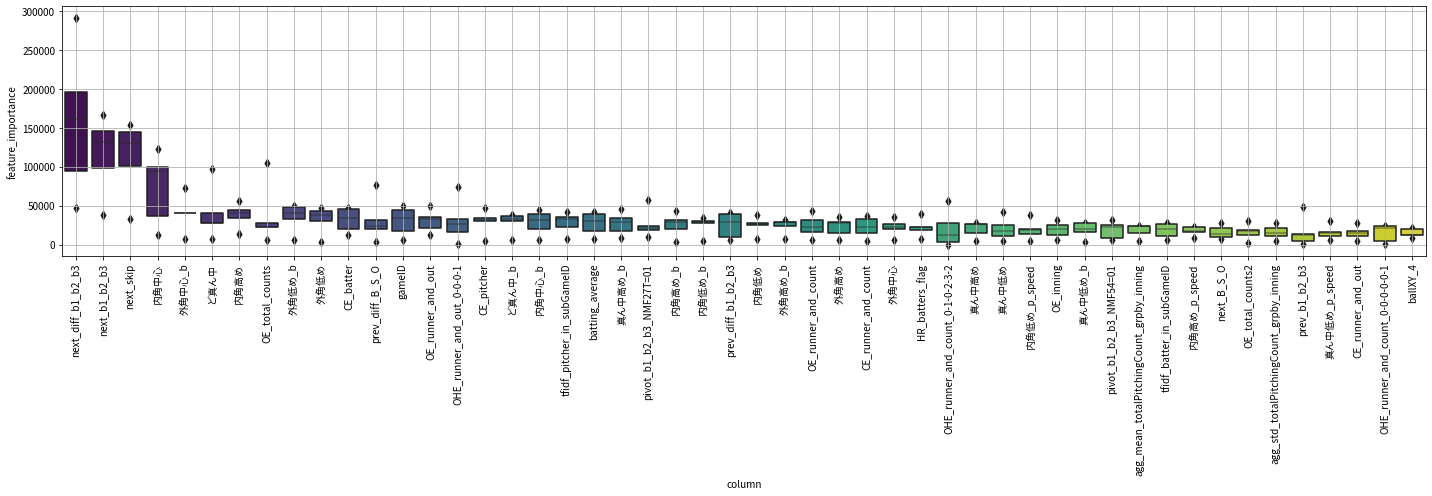

In [42]:
fig, ax = visualize_importance(models, train_x)

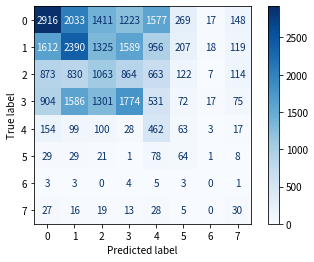

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred=oof, y_true=train_ys)
cmp = ConfusionMatrixDisplay(cm)

cmp.plot(cmap=plt.cm.Blues)

In [44]:
from scipy.stats import mode
oof_df = pd.DataFrame({'y1': oof,
                       'y2': oof2,
                       'y3': oof3,
                       'y4': oof4,
                       'y5': oof5})

oof_df["y"] = oof_df[['y1', 'y2', 'y3', 'y4', 'y5']].mode(axis=1)[0].astype(int)

f1_score(train_ys, oof_df["y"], average="macro") 

0.21394320803404085

In [45]:
pred_lgb = np.array([model.predict(test_x.values) for model in models])
pred_lgb2 = np.array([model.predict(test_x.values) for model in models2])
pred_lgb3 = np.array([model.predict(test_x.values) for model in models3])
pred_lgb4 = np.array([model.predict(test_x.values) for model in models4])
pred_lgb5 = np.array([model.predict(test_x.values) for model in models5])

In [46]:
from scipy.stats import mode
pred_lgbs = mode(pred_lgb)[0][0]
pred_lgbs2 = mode(pred_lgb2)[0][0]
pred_lgbs3 = mode(pred_lgb3)[0][0]
pred_lgbs4 = mode(pred_lgb4)[0][0]
pred_lgbs5 = mode(pred_lgb5)[0][0]

In [47]:
submit_df = pd.DataFrame({'y1': pred_lgbs,
                          'y2': pred_lgbs2,
                          'y3': pred_lgbs3,
                          'y4': pred_lgbs4,
                          'y5': pred_lgbs5})
submit_df.index.name = 'id'
submit_df["y"] = submit_df[['y1', 'y2', 'y3', 'y4', 'y5']].mode(axis=1)[0].astype(int)
submit_df

,y1,y2,y3,y4,y5,y
id,,,,,,
0,4.0,4.0,4.0,3.0,4.0,4
1,5.0,5.0,5.0,5.0,5.0,5
2,2.0,2.0,2.0,2.0,2.0,2
3,3.0,3.0,3.0,3.0,3.0,3
4,0.0,0.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...
33803,5.0,5.0,5.0,5.0,5.0,5
33804,3.0,3.0,3.0,3.0,3.0,3
33805,0.0,0.0,0.0,0.0,0.0,0


In [48]:
submission = submit_df[["y"]]

In [49]:
submission

,y
id,
0,4
1,5
2,2
3,3
4,1
...,...
33803,5
33804,3
33805,0


In [50]:
submission.to_csv(emp+'submission.csv')

In [51]:
np.unique(mode(pred_lgb)[0][0])

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

<AxesSubplot:xlabel='y', ylabel='count'>

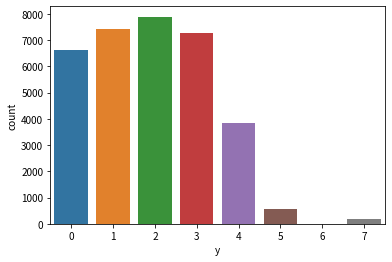

In [52]:
sns.countplot(submission.y)

<AxesSubplot:ylabel='count'>

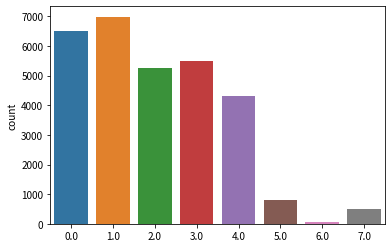

In [53]:
sns.countplot(oof)

In [54]:
submission.y.value_counts()

2    7893
1    7433
3    7267
0    6620
4    3858
5     548
7     184
6       5
Name: y, dtype: int64